In [372]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates

In [373]:
# reading in COVID-19 datasets
dem_df = pd.read_csv('../data/demographics.csv')
eco_df = pd.read_csv('../data/economy.csv')
epi_df = pd.read_csv('../data/epidemiology.csv')
vac_df = pd.read_csv('../data/vaccinations.csv')
idx_df = pd.read_csv('../data/index.csv')

In [374]:
us_epi_df = epi_df.loc[epi_df['location_key'] == 'US']
us_vac_df = vac_df.loc[vac_df['location_key'] == 'US']
us_ev_df = us_epi_df.merge(us_vac_df, on='date', how='inner')
us_ev_df

,date,location_key_x,new_confirmed,new_deceased,new_recovered,new_tested,cumulative_confirmed,cumulative_deceased,cumulative_recovered,cumulative_tested,...,new_persons_fully_vaccinated_janssen,cumulative_persons_fully_vaccinated_janssen,new_vaccine_doses_administered_janssen,cumulative_vaccine_doses_administered_janssen,new_persons_vaccinated_sinovac,total_persons_vaccinated_sinovac,new_persons_fully_vaccinated_sinovac,total_persons_fully_vaccinated_sinovac,new_vaccine_doses_administered_sinovac,total_vaccine_doses_administered_sinovac
0,2020-12-13,US,177830.0,2021.0,NaN,1495092.0,16119805.0,287276.0,NaN,228772064.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-12-14,US,195630.0,1996.0,NaN,1946701.0,16315435.0,289272.0,NaN,230718765.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-12-15,US,197440.0,2724.0,NaN,2078178.0,16512875.0,291996.0,NaN,232796943.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-12-16,US,237037.0,3374.0,NaN,2053475.0,16749912.0,295370.0,NaN,234850418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-12-17,US,242528.0,3316.0,NaN,2022937.0,16992440.0,298686.0,NaN,236873355.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,2022-09-10,US,19715.0,51.0,NaN,NaN,92225201.0,1003766.0,NaN,NaN,...,0.0,17094523.0,0.0,18881650.0,NaN,NaN,NaN,NaN,NaN,NaN
637,2022-09-11,US,16742.0,10.0,NaN,NaN,92241943.0,1003776.0,NaN,NaN,...,0.0,17094523.0,0.0,18881650.0,NaN,NaN,NaN,NaN,NaN,NaN
638,2022-09-12,US,60728.0,213.0,NaN,NaN,92302671.0,1003989.0,NaN,NaN,...,0.0,17094523.0,0.0,18881650.0,NaN,NaN,NaN,NaN,NaN,NaN
639,2022-09-13,US,54413.0,460.0,NaN,NaN,92357092.0,1004449.0,NaN,NaN,...,0.0,17094523.0,0.0,18881650.0,NaN,NaN,NaN,NaN,NaN,NaN


In [375]:
# convert data to sliding window

cases = pd.DataFrame(us_ev_df['new_confirmed'])
cols = list()
cols.append(cases.shift(1))
cols.append(cases)

cases_new = pd.concat(cols, axis=1)
cases_new = cases_new.set_axis(['before', 'after'], axis=1)
cases_new = cases_new.tail(-1)
cases_sw = np.array(cases_new)
cases_new

,before,after
1,177830.0,195630.0
2,195630.0,197440.0
3,197440.0,237037.0
4,237037.0,242528.0
5,242528.0,233736.0
...,...,...
636,81861.0,19715.0
637,19715.0,16742.0
638,16742.0,60728.0
639,60728.0,54413.0


In [376]:
def Poisson(X, Y, stepSize, rho):

    print("calling poisson")

    # Check if univariate (can't take len of a float)
    try:
        theta = [0 for i in range(len(X[0]))]
    except:
        theta = [0]

    its = 0


    while its < 10000:
        

        # Compute Gradient Descent
        thetaPrime = ComputeGrad(X, Y, theta)

        # Check if slope is less than some desired value (we are close to optimal)
        if np.linalg.norm(thetaPrime) < rho:
            print("number of iterations:", its)
            intercept = FindIntercept(X, Y, theta)
            return theta, intercept


        # optimizer to reduce step size if we run for too many iterations
        if its % 1000 == 0:
            print(theta)
            stepSize = stepSize / 10

        # Progress towards optimal
        theta = theta + stepSize*thetaPrime



        its += 1

    print("number of iterations:", its)
    return theta

def ComputeLikelihood(X, Y, theta):

    logLikelihood = 0

    # For all data points,
    for i in range(len(X)):

        logLikelihood += (np.dot(theta, X[i]) * Y[i]) - np.exp(np.dot(theta, X[i]))



    return logLikelihood


def ComputeGrad(X, Y, theta):
    
    
    # Initialize gradient at zero
    gradient = 0

    # For all data points,
    for i in range(len(X)):

        # l' = sum(xiyi - xie^bxi) for all i
        
        tx = np.dot(theta, X[i])
        gradient += Y[i]*X[i] - X[i]*np.exp(tx)
        

    # Using exponents, so this is necessary to avoid overflow
    # Set a hard cap on how large theta prime can be
    # Won't change correctness, but may significantly increase number of iterations
    for i in range(len(gradient)):
        if gradient[i] < -1000000:
            gradient[i] = -1000000
        elif gradient[i] > 1000000:
            gradient[i] = 1000000
    
    
    return gradient



def FindIntercept(X, Y, model):
    intercept = np.mean(Y) - np.exp(np.dot(np.mean(X), model))[0]
    return intercept

In [377]:
poisson_vals = list()


X = cases_sw[:, :-1] / 1000000
Y = cases_sw[:, -1] / 1000000

print(Poisson(X, Y, 1, 0.000001))


calling poisson
[0]
number of iterations: 66
(array([-8.50965966]), -0.24648760351083002)


In [357]:
Poisson(X, Y, 0.000000000001, 0.1)

calling poisson
[0]
[-5.53263581e-09]
[-6.08589939e-09]
[-6.14122575e-09]
[-6.14675839e-09]
[-6.14731165e-09]
[-6.14736698e-09]
[-6.14737251e-09]
[-6.14737306e-09]
[-6.14737312e-09]
number of iterations: 10000


array([-6.14737312e-09])

In [378]:
X = cases_sw[:, :-1]
Y = cases_sw[:, -1]

'cases = pd.DataFrame(us_ev_df[\'new_confirmed\'])\ncols = list()\ncols.append(cases.shift(1))\ncols.append(cases)\n\nvacc = us_ev_df["new_persons_vaccinated"]\nvacc.pop(640)\n\ncols.append(vacc)'

In [95]:
Poisson(X, Y, 0.0000000001, 0.1)

calling poisson
[0, 0]
[0. 0.]
[8.e-06 8.e-06]
[6.8e-06 1.0e-05]
[6.180e-06 1.078e-05]
[6.1400e-06 1.0828e-05]
[6.1400e-06 1.0828e-05]
[6.13956000e-06 1.08283729e-05]
[6.13951570e-06 1.08284062e-05]
[6.13951490e-06 1.08284055e-05]
number of iterations: 9439


array([6.13951471e-06, 1.08284056e-05])

In [402]:
def RegressPoisson(data, batch, Xcols, Ycols):
    
    pois_vals = list()
    pois_acc = list()
    pois_all_true = list()
    pois_all_preds = list()

    for i in range(batch):
        pois_true = list()
        pois_pred = list()
        train, test = train_test_split(cases_sw, int((0.2+i/100) * len(cases_sw)))
        train = train / 1000000
        test = test / 1000000
        pois, intercept = Poisson(train[:, Xcols], train[:, Ycols], 1, 0.01)
        pois_vals.append(pois)
        error, pois_pred, pois_true = Test(test[:, Xcols], test[:, Ycols], pois, pois_pred, pois_true, intercept)
        pois_acc.append(error)
        pois_all_preds.append(pois_pred)
        pois_all_true.append(pois_true)
    
    
    
    
    return pois_all_true, pois_all_preds, pois_acc, pois_vals

def GraphPoisson(pois_all_true, pois_all_pred):
    fig, ax = plt.subplots(5, 6, figsize=(15,10))

    for i in range(len(pois_all_preds)-1):
        ax[i // 6, i % 6].plot([k for k in range(len(pois_all_true[i]))], pois_all_true[i], pois_all_preds[i])
        ax[i//6, i%6].set_title("batch size =" + str(len(pois_all_true[i])))
    fig.legend(["true", "predicted"], loc = "upper left")
    fig.tight_layout()
    return 
    
    

In [380]:
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [381]:
def Test(X, Y, model, pois_pred, pois_true, intercept):
    
    #print("intercept", intercept)
    testingAccuracy = 0

    for i in range(len(X)):
        
        predicted = np.exp(X[i]*model)[0] + intercept
        actual = Y[i]
        testingAccuracy += (actual - predicted)**2
        pois_pred.append(predicted)
        pois_true.append(actual)

    return testingAccuracy, pois_pred, pois_true

In [404]:
pois_all_true, pois_all_preds, pois_acc, pois_vals = RegressPoisson(cases_sw, 31, [0], 1)

calling poisson
[0]
number of iterations: 26
calling poisson
[0]
number of iterations: 26
calling poisson
[0]
number of iterations: 25
calling poisson
[0]
number of iterations: 25
calling poisson
[0]
number of iterations: 24
calling poisson
[0]
number of iterations: 24
calling poisson
[0]
number of iterations: 24
calling poisson
[0]
number of iterations: 24
calling poisson
[0]
number of iterations: 23
calling poisson
[0]
number of iterations: 23
calling poisson
[0]
number of iterations: 23
calling poisson
[0]
number of iterations: 22
calling poisson
[0]
number of iterations: 22
calling poisson
[0]
number of iterations: 22
calling poisson
[0]
number of iterations: 22
calling poisson
[0]
number of iterations: 23
calling poisson
[0]
number of iterations: 26
calling poisson
[0]
number of iterations: 33
calling poisson
[0]
number of iterations: 46
calling poisson
[0]
number of iterations: 80
calling poisson
[0]
number of iterations: 131
calling poisson
[0]
number of iterations: 170
calling 

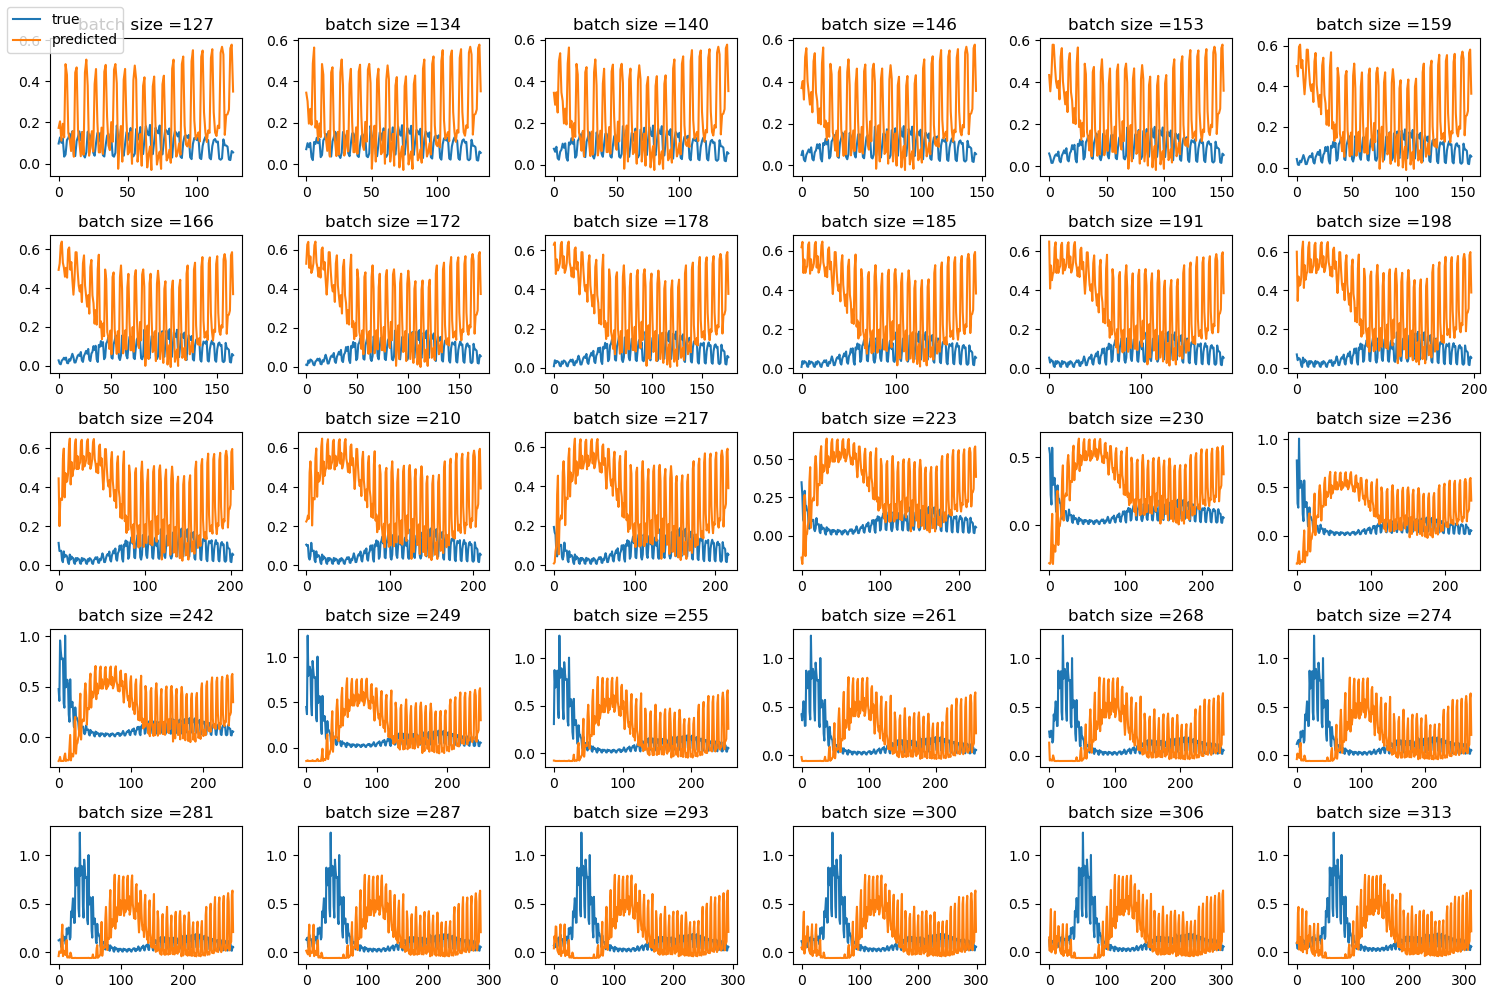

In [405]:
GraphPoisson(pois_all_true, pois_all_preds)

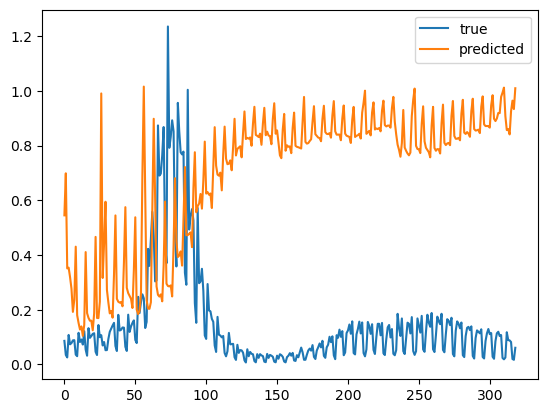

In [406]:
plt.plot([i for i in range(len(pois_true))], pois_true, pois_pred)
plt.legend(["true", "predicted"])

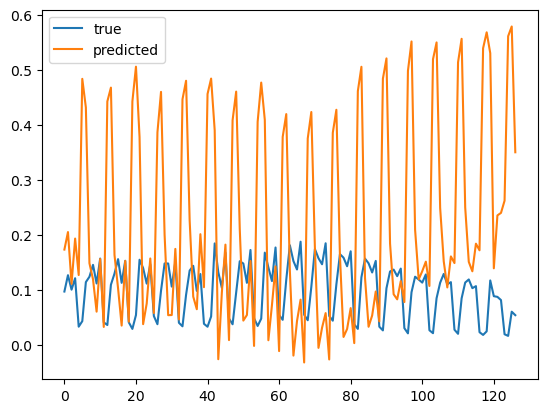

In [407]:
plt.plot([i for i in range(len(pois_all_true[0]))], pois_all_true[0], pois_all_preds[0])
plt.legend(["true", "predicted"])

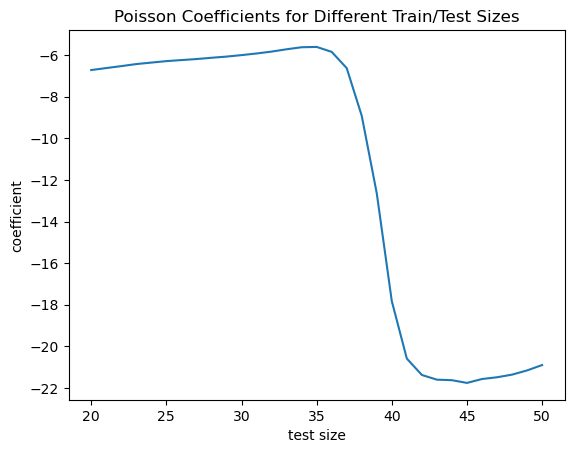

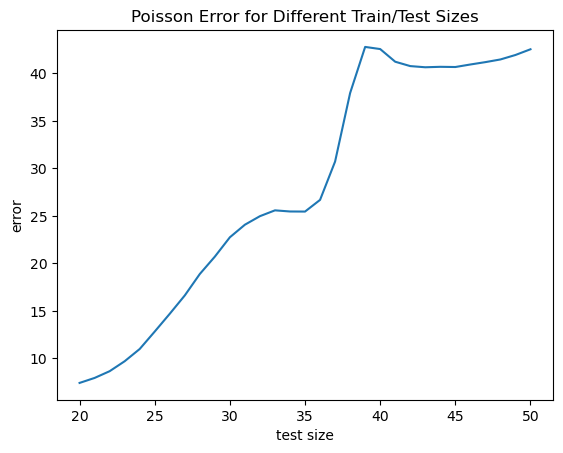

In [366]:
plt.plot(range(20, 51, 1), pois_vals)
plt.xlabel('test size')
plt.ylabel('coefficient')
plt.title('Poisson Coefficients for Different Train/Test Sizes')
plt.show()

plt.plot(range(20, 51, 1), pois_acc)
plt.xlabel('test size')
plt.ylabel('error')
plt.title('Poisson Error for Different Train/Test Sizes')
plt.show()

In [385]:

cases = pd.DataFrame(us_ev_df['new_confirmed'])
cols = list()
cols.append(cases.shift(1))
cols.append(cases)

vacc = us_ev_df["new_persons_vaccinated"]
vacc.pop(640)

cols.append(vacc)


In [386]:

cases_new = pd.concat(cols, axis=1)
cases_new = cases_new.set_axis(['before', "vacc", 'after'], axis=1)
cases_new = cases_new.tail(-1)
cases_new = cases_new.dropna()
cases_sw = np.array(cases_new)
cases_new


,before,vacc,after
1,177830.0,195630.0,4538.0
2,195630.0,197440.0,45876.0
3,197440.0,237037.0,154818.0
4,237037.0,242528.0,266883.0
5,242528.0,233736.0,409980.0
...,...,...,...
635,87686.0,81861.0,51224.0
636,81861.0,19715.0,26248.0
637,19715.0,16742.0,15585.0
638,16742.0,60728.0,23997.0


In [387]:
pois_all_true, pois_all_preds, pois_acc, pois_vals = RegressPoisson(cases_sw, 31, [0,2], 1)

calling poisson
[0, 0]
number of iterations: 26
calling poisson
[0, 0]
number of iterations: 26
calling poisson
[0, 0]
number of iterations: 25
calling poisson
[0, 0]
number of iterations: 25
calling poisson
[0, 0]
number of iterations: 25
calling poisson
[0, 0]
number of iterations: 25
calling poisson
[0, 0]
number of iterations: 24
calling poisson
[0, 0]
number of iterations: 24
calling poisson
[0, 0]
number of iterations: 24
calling poisson
[0, 0]
number of iterations: 24
calling poisson
[0, 0]
number of iterations: 23
calling poisson
[0, 0]
number of iterations: 23
calling poisson
[0, 0]
number of iterations: 23
calling poisson
[0, 0]
number of iterations: 23
calling poisson
[0, 0]
number of iterations: 22
calling poisson
[0, 0]
number of iterations: 22
calling poisson
[0, 0]
number of iterations: 22
calling poisson
[0, 0]
number of iterations: 25
calling poisson
[0, 0]
number of iterations: 32
calling poisson
[0, 0]
number of iterations: 67
calling poisson
[0, 0]
number of iterati

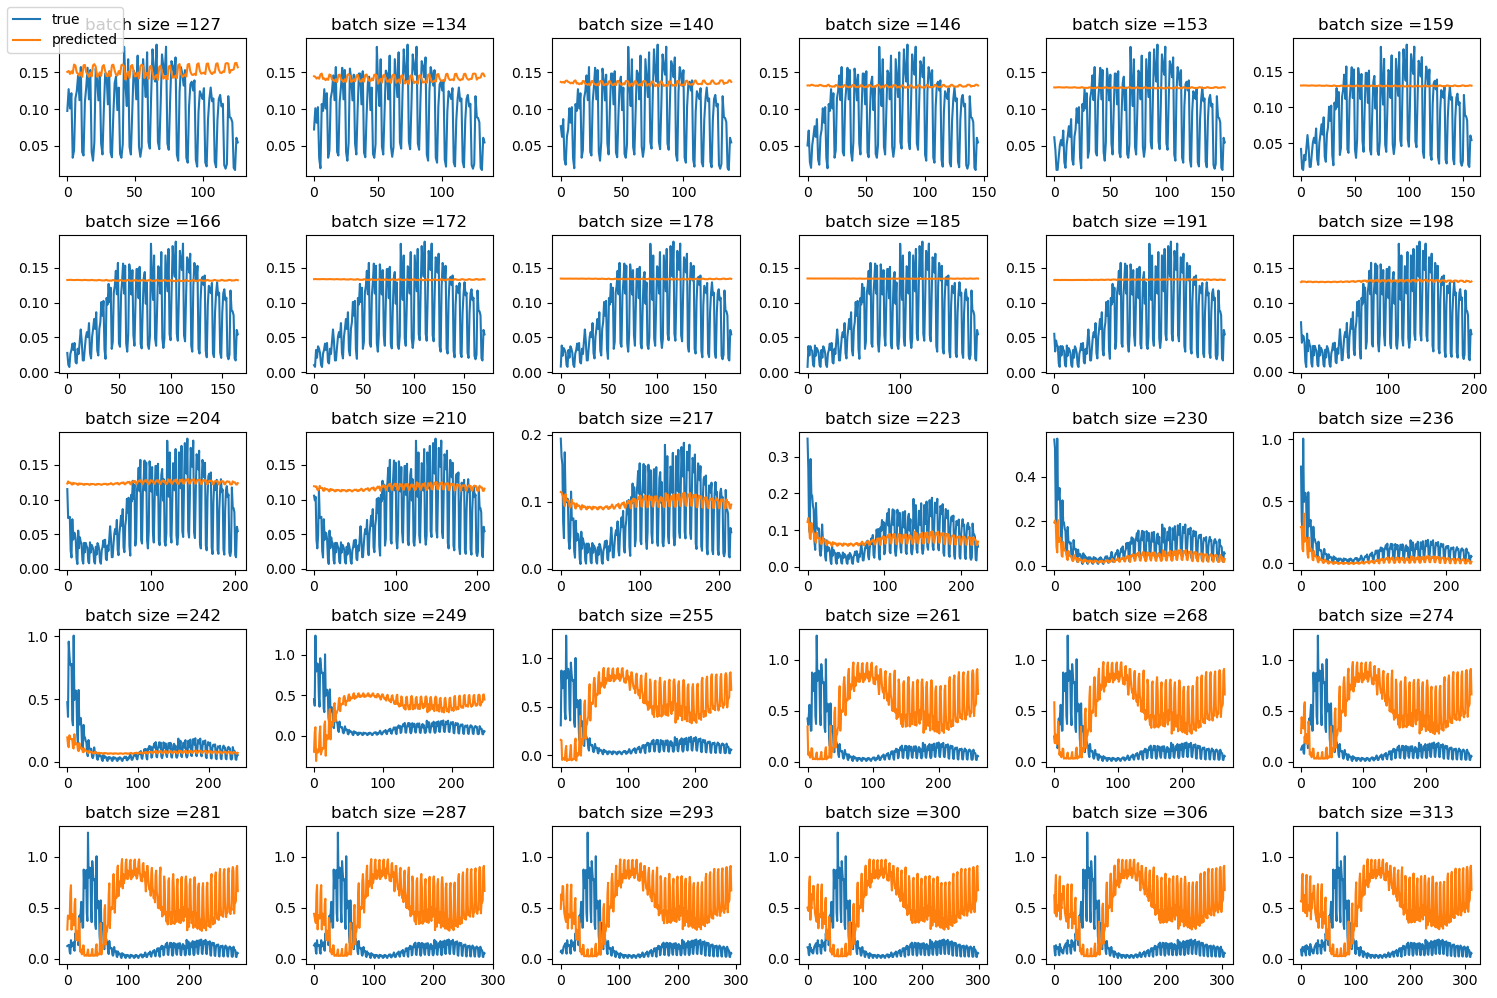

In [403]:
GraphPoisson(pois_all_true, pois_all_preds)

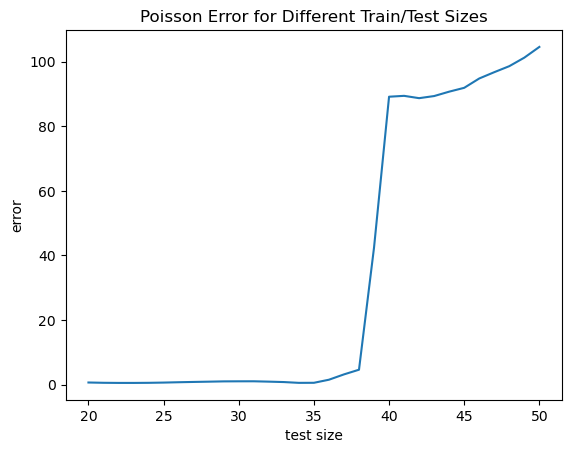

In [347]:
plt.plot(range(20, 51, 1), pois_acc)
plt.xlabel('test size')
plt.ylabel('error')
plt.title('Poisson Error for Different Train/Test Sizes')
plt.show()

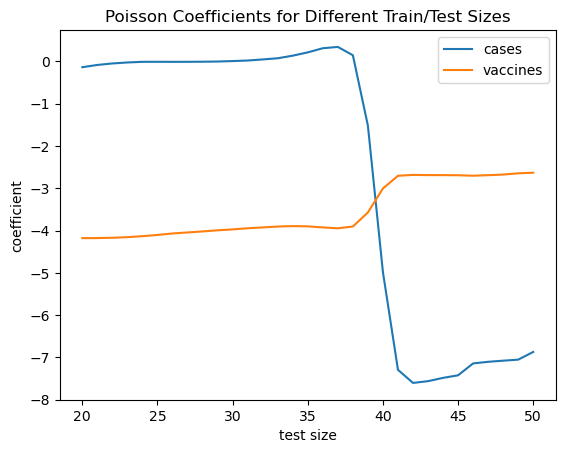

In [399]:
plt.plot(range(20, 51, 1), pois_vals)
plt.xlabel('test size')
plt.ylabel('coefficient')
plt.title('Poisson Coefficients for Different Train/Test Sizes')
plt.legend(["cases", "vaccines"])
plt.show()

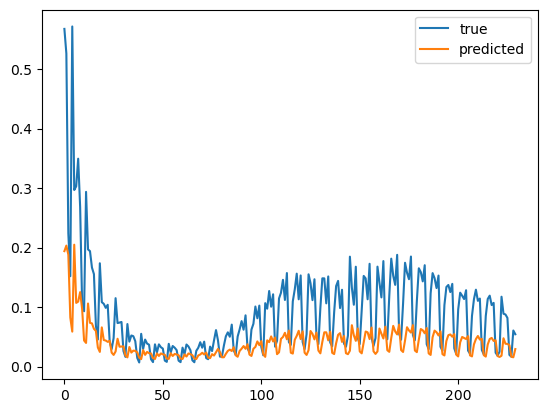

In [397]:
plt.plot([i for i in range(len(pois_all_true[16]))], pois_all_true[16], pois_all_preds[16])
plt.legend(["true","predicted"])